# Practical 2: Convolutional Neural Networks

**Open notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/asci_cbl_practicals/blob/main/notebooks/2_CNNs.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/asci_cbl_practicals/blob/main/notebooks/2_CNNs.ipynb)     
**Authors:** Phillip Lippe

In this practical, we will implement variants of modern CNN architectures. There have been many different architectures been proposed over the past few years. Some of the most impactful ones, and still relevant today, are the following: [GoogleNet](https://arxiv.org/abs/1409.4842)/Inception architecture (winner of ILSVRC 2014), [ResNet](https://arxiv.org/abs/1512.03385) (winner of ILSVRC 2015), and [DenseNet](https://arxiv.org/abs/1608.06993) (best paper award CVPR 2017). All of them were state-of-the-art models when being proposed, and the core ideas of these networks are the foundations for most current state-of-the-art architectures. Thus, it is important to understand these architectures and learn how to implement some of them.

Let's start with importing our standard libraries here.

In [55]:
Colab_server=False
if Colab_server:
  from google.colab import drive
  drive.mount('/content/drive')

In [56]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

We will use the same the path variables `DATASET_PATH` and `CHECKPOINT_PATH`. Adjust the paths if necessary.

In [57]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "~/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "~/saved_models/practical2"
if Colab_server:
  #CHECKPOINT_PATH = "/content/drive/MyDrive/saved_models/practical2"
  os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


Similarly as in the last practical, we use the CIFAR10 dataset and load it below:

In [58]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# Create data loaders for later. Adjust batch size if you have a smaller GPU
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## PyTorch Lightning

In this practical and in many following ones, we will make use of the library [PyTorch Lightning](https://www.pytorchlightning.ai/). PyTorch Lightning is a framework that simplifies your code needed to train, evaluate, and test a model in PyTorch. It also handles logging into [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), a visualization toolkit for ML experiments, and saving model checkpoints automatically with minimal code overhead from our side. This is extremely helpful for us as we want to focus on implementing different model architectures and spend little time on other code overhead. Note that at the time of writing/teaching, the framework has been released in version 1.6. Future versions might have a slightly changed interface and thus might not work perfectly with the code (we will try to keep it up-to-date as much as possible).

Now, we will take the first step in PyTorch Lightning, and continue to explore the framework in our other tutorials. First, we import the library:

In [59]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl

PyTorch Lightning comes with a lot of useful functions, such as one for setting the seed:

In [60]:
# Setting the seed
pl.seed_everything(42)

Seed set to 42


42

Thus, in the future, we don't have to define our own `set_seed` function anymore.

In PyTorch Lightning, we define `pl.LightningModule`'s (inheriting from `torch.nn.Module`) that organize our code into 5 main sections:

1. Initialization (`__init__`), where we create all necessary parameters/models
2. Optimizers (`configure_optimizers`) where we create the optimizers, learning rate scheduler, etc.
3. Training loop (`training_step`) where we only have to define the loss calculation for a single batch (the loop of optimizer.zero_grad(), loss.backward() and optimizer.step(), as well as any logging/saving operation, is done in the background)
4. Validation loop (`validation_step`) where similarly to the training, we only have to define what should happen per step
5. Test loop (`test_step`) which is the same as validation, only on a test set.

Therefore, we don't abstract the PyTorch code, but rather organize it and define some default operations that are commonly used. If you need to change something else in your training/validation/test loop, there are many possible functions you can overwrite (see the [docs](https://pytorch-lightning.readthedocs.io/en/stable/lightning_module.html) for details).

Now we can look at an example of how a Lightning Module for training a CNN looks like:

In [61]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_hparams, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.create_model()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def create_model(self):
        # No need to fill this yet, we will do it later in the notebook
        # Currently this function is a placeholder to create our model
        raise NotImplementedError

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # Create optimizer
        optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        # We will reduce the learning rate by 0.1 after 75 and 100 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[70, 90], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

class CIFARModule(pl.LightningModule):

    def __init__(self, model_hparams, optimizer_hparams):
        super().__init__()
        self.save_hyperparameters()
        self.create_model()
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def create_model(self):
        self.model = ResNet(num_classes=self.hparams.model_hparams['num_classes'],
                            num_blocks=self.hparams.model_hparams['num_blocks'],
                            c_hidden=self.hparams.model_hparams['c_hidden'])

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70, 90], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Log the training loss and accuracy per batch
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)


We see that the code is organized and clear, which helps if someone else tries to understand your code.

Another important part of PyTorch Lightning is the concept of callbacks. Callbacks are self-contained functions that contain the non-essential logic of your Lightning Module. They are usually called after finishing a training epoch, but can also influence other parts of your training loop. For instance, we will use the following two pre-defined callbacks: `LearningRateMonitor` and `ModelCheckpoint`. The learning rate monitor adds the current learning rate to our TensorBoard, which helps to verify that our learning rate scheduler works correctly. The model checkpoint callback allows you to customize the saving routine of your checkpoints. For instance, how many checkpoints to keep, when to save, which metric to look out for, etc. We import them below:

In [62]:
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint,Callback

# Custom callback for periodic test accuracy logging
class PeriodicTestAccuracyLogger(Callback):
    def __init__(self, test_loader, print_freq=5):
        super().__init__()
        self.test_loader = test_loader
        self.print_freq = print_freq

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.print_freq == 0:
            test_results = trainer.test(dataloaders=self.test_loader, verbose=False)
            test_acc = test_results[0]['test_acc']
            print(f"Epoch {trainer.current_epoch}: Test Accuracy = {test_acc:.4f}")


Besides the Lightning module, the second most important module in PyTorch Lightning is the `Trainer`. The trainer is responsible to execute the training steps defined in the Lightning module and completes the framework. Similar to the Lightning module, you can override any key part that you don't want to be automated, but the default settings are often the best practice to do. For a full overview, see the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/trainer.html). The most important functions we use below are:

* `trainer.fit`: Takes as input a lightning module, a training dataset, and an (optional) validation dataset. This function trains the given module on the training dataset with occasional validation (default once per epoch, can be changed)
* `trainer.test`: Takes as input a model and a dataset on which we want to test. It returns the test metric on the dataset.

For training and testing, we don't have to worry about things like setting the model to eval mode (`model.eval()`) as this is all done automatically. See below how we define a training function for our models:

In [63]:
from pytorch_lightning.loggers import CSVLogger
# Define the CSV logger
#logger = CSVLogger(save_dir=CHECKPOINT_PATH, name="ResNet_logs")
def train_model_0(save_name, data_loaders, max_epochs=100, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """



    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                        #  gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                        accelerator="auto",
                         max_epochs=max_epochs,                                                              # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         check_val_every_n_epoch=10)                                                        # Frequency with which we evaluate the model
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(**kwargs)
        trainer.fit(model, data_loaders['train'], data_loaders['val'])
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, data_loaders['val'], verbose=False)
    test_result = trainer.test(model, data_loaders['test'], verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result


def train_model(save_name, data_loaders, max_epochs=100, **kwargs):

    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")

    # Check for a pretrained model
    '''if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename)
        # Test the best model
        trainer_test = pl.Trainer(
            logger=False,              # Disable logger
            enable_checkpointing=False # Disable checkpoints
        )
        val_result = trainer_test.test(model, data_loaders['val'], verbose=False)
        test_result = trainer_test.test(model, data_loaders['test'], verbose=False)
        result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
        print(f'model existed in {pretrained_filename} with result of {result}')
        x=input('continue?\n')
        if x!='Y':
            return model,result'''



    # ModelCheckpoint for saving the latest checkpoint
    checkpoint_callback = ModelCheckpoint(
        dirpath=CHECKPOINT_PATH,
        filename=f"{save_name}",
        save_top_k=1,  # Only keep the best model
        monitor="val_acc",
        mode="max",
        save_weights_only=False,  # Save optimizer and scheduler states
    )

    # LearningRateMonitor callback
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    # Custom test accuracy logger
    test_logger = PeriodicTestAccuracyLogger(test_loader=data_loaders['test'], print_freq=5)

    # Trainer setup
    trainer = pl.Trainer(
        gradient_clip_val=1.0,
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),
        accelerator="auto",
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, lr_monitor, test_logger],
        check_val_every_n_epoch=1,
        #logger=logger,
    )

    trainer.logger._log_graph = True
    print(f'trainer log dir:{trainer.logger.log_dir}')

    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename)
        # Test the best model
        trainer.logger=None
        val_result = trainer.test(model, data_loaders['val'], verbose=False)
        test_result = trainer.test(model, data_loaders['test'], verbose=False)
        result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
        print(f'model existed in {pretrained_filename} with result of {result}')
        x=input('continue?\n')
        if x!='Y':
            return model,result
    if not os.path.isfile(pretrained_filename):
    #else:
        print(f'model do not existed in {pretrained_filename}')
        pl.seed_everything(42)
        model = CIFARModule(**kwargs)
        trainer.fit(model, data_loaders['train'], data_loaders['val'])

    # Load the best model checkpoint for testing
    best_model_path = checkpoint_callback.best_model_path
    print(f"loading model from checkpoint {best_model_path}")
    model = CIFARModule.load_from_checkpoint(best_model_path)

    # Test the best model
    val_result = trainer.test(model, data_loaders['val'], verbose=False)
    test_result = trainer.test(model, data_loaders['test'], verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

This setup simplifies our training a lot, and we recommend using PyTorch Lightning for future practicals as well.

## Part 1: ResNet

In the first part of the practical, you will implement a small ResNet. The [ResNet](https://arxiv.org/abs/1512.03385) paper is one of the  [most cited AI papers](https://www.natureindex.com/news-blog/google-scholar-reveals-most-influential-papers-research-citations-twenty-twenty), and has been the foundation for neural networks with more than 1,000 layers. Despite its simplicity, the idea of residual connections is highly effective as it supports stable gradient propagation through the network. Instead of modeling $x_{l+1}=F(x_{l})$, we model $x_{l+1}=x_{l}+F(x_{l})$ where $F$ is a non-linear mapping (usually a sequence of NN modules likes convolutions, activation functions, and normalizations). If we do backpropagation on such residual connections, we obtain:

$$\frac{\partial x_{l+1}}{\partial x_{l}} = \mathbf{I} + \frac{\partial F(x_{l})}{\partial x_{l}}$$

The bias towards the identity matrix guarantees a stable gradient propagation being less effected by $F$ itself. There have been many variants of ResNet proposed, which mostly concern the function $F$, or operations applied on the sum. In this tutorial, we look at two of them: the original ResNet block, and the [Pre-Activation ResNet block](https://arxiv.org/abs/1603.05027). We visually compare the blocks below (figure credit - [He et al.](https://arxiv.org/abs/1603.05027)):

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/resnet_block.svg?raw=1" style="display: block; margin-left: auto; margin-right: auto;" width="300px"/></center>

The original ResNet block applies a non-linear activation function, usually ReLU, after the skip connection. In contrast, the pre-activation ResNet block applies the non-linearity at the beginning of $F$. Both have their advantages and disadvantages. For very deep network, however, the pre-activation ResNet has shown to perform better as the gradient flow is guaranteed to have the identity matrix as calculated above, and is not harmed by any non-linear activation applied to it. For comparison, in this notebook, we implement both ResNet types as shallow networks.

For this practical, we will use the Pre-Activation ResNet block. The visualization above already shows what layers are included in $F$. One special case we have to handle is when we want to reduce the image dimensions in terms of width and height. The ResNet block requires $F(x_{l})$ to be of the same shape as $x_{l}$. Thus, we need to change the dimensionality of $x_{l}$ as well before adding to $F(x_{l})$. The original implementation used an identity mapping with stride 2 and padded additional feature dimensions with 0. However, the more common implementation is to use a 1x1 convolution with stride 2 as it allows us to change the feature dimensionality while being efficient in parameter and computation cost. Let's try to implement the ResNet block below:

In [64]:
class PreActResNetBlock(nn.Module):

      def __init__(self, c_in, subsample=False, c_out=-1):
          """
          Inputs:
              c_in - Number of input features
              subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
              c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
          """
          super().__init__()
      #     # TODO: Implement the network of the pre-activation ResNet block
      #     raise NotImplementedError

      # def forward(self, x):
      #     # TODO: Implement the forward pass of the Pre-Activation ResNet block
      #     raise NotImplementedError

          if subsample:
              self.stride = 2
              self.c_out = c_out if c_out > 0 else c_in
          else:
              self.stride = 1
              self.c_out = c_in

          # First normalization and activation (pre-activation)
          self.bn1 = nn.BatchNorm2d(c_in)
          self.relu1 = nn.ReLU(inplace=True)

          # First convolution
          self.conv1 = nn.Conv2d(c_in, self.c_out, kernel_size=3, stride=self.stride, padding=1, bias=False)

          # Second normalization and activation (pre-activation)
          self.bn2 = nn.BatchNorm2d(self.c_out)
          self.relu2 = nn.ReLU(inplace=True)

          # Second convolution
          self.conv2 = nn.Conv2d(self.c_out, self.c_out, kernel_size=3, stride=1, padding=1, bias=False)

          # Shortcut (identity or 1x1 convolution)
          if subsample or c_in != self.c_out:
              self.shortcut = nn.Conv2d(c_in, self.c_out, kernel_size=1, stride=self.stride, bias=False)
          else:
              self.shortcut = nn.Identity()

      def forward(self, x):
          # Save the shortcut connection
          shortcut = self.shortcut(x)

          # first BN -> ReLU -> Conv
          out = self.bn1(x)
          out = self.relu1(out)
          out = self.conv1(out)

          # second BN -> ReLU -> Conv
          out = self.bn2(out)
          out = self.relu2(out)
          out = self.conv2(out)

          # Add the shortcut
          out += shortcut

          return out



In [65]:
# Testing the ResNet block
c_in = np.random.randint(low=16, high=64)
module = PreActResNetBlock(c_in=c_in, subsample=False)
module.to(device)
img = torch.randn(4, c_in, 32, 32, device=device)
out = module(img)
for i in range(len(img.shape)):
    assert out.shape[i] == img.shape[i], f'Disagreement in shapes: output={out.shape}, input={img.shape}'

c_out = np.random.randint(low=16, high=64)
module = PreActResNetBlock(c_in=c_in, subsample=True, c_out=c_out)
module.to(device)
img = torch.randn(4, c_in, 32, 32, device=device)
out = module(img)
assert out.shape[1] == c_out
assert out.shape[2] == img.shape[2]//2
assert out.shape[3] == img.shape[3]//2

Now that we have the ResNet block, let's implement the full ResNet. The overall ResNet architecture consists of stacking multiple ResNet blocks, of which some are downsampling the input. When talking about ResNet blocks in the whole network, we usually group them by the same output shape. Hence, if we say the ResNet has `[3,3,3]` blocks, it means that we have 3 times a group of 3 ResNet blocks, where a subsampling is taking place in the fourth and seventh block. The ResNet with `[3,3,3]` blocks on CIFAR10 is visualized below.

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/resnet_notation.svg?raw=1" width="500px"></center>

The three groups operate on the resolutions $32\times32$, $16\times16$ and $8\times8$ respectively. The blocks in orange denote ResNet blocks with downsampling. Additionally to these blocks, we have one initial convolution that maps the 3 color channels to the initial hidden channels, and a final linear layer after an average pooling over all features. Let's implement it below:

In [66]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,24,32]):
        """
        Inputs:
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks.
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_blocks = num_blocks
        self.c_hidden = c_hidden
        self._create_network()
        self._init_params()

    def _create_network(self):
        # TODO: Create network with stacking blocks
        # raise NotImplementedError
        layers = []

        # Initial convolution
        layers.append(nn.Conv2d(3, self.c_hidden[0], kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(self.c_hidden[0]))
        layers.append(nn.ReLU(inplace=True))

        # ResNet blocks
        c_in = self.c_hidden[0]
        for idx, num_block in enumerate(self.num_blocks):
            c_out = self.c_hidden[idx]
            for block_idx in range(num_block):
                subsample = block_idx == 0 and idx > 0  # Subsample for the first block of each group except the first
                layers.append(PreActResNetBlock(c_in, subsample=subsample, c_out=c_out))
                c_in = c_out

        # Global average pooling and final linear layer
        layers.append(nn.AdaptiveAvgPool2d(1))  # Global average pooling
        layers.append(nn.Flatten())
        layers.append(nn.Linear(self.c_hidden[-1], self.num_classes))

        self.network = nn.Sequential(*layers)

    def _init_params(self):
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # TODO: Implement forward of ResNet
         return self.network(x)

In [67]:
# Testing the ResNet
num_classes = np.random.randint(low=5, high=20)
model = ResNet(num_classes=num_classes)
model.to(device)
img = torch.randn(4, 3, 32, 32, device=device)
out = model(img)
assert len(out.shape) == 2
assert out.shape[0] == img.shape[0]
assert out.shape[1] == num_classes

Now that we have all together, let's train the model. First, we need to define the `create_model` function in the `CIFARModule`:

In [68]:
def create_resnet(self):
    self.model = ResNet(num_classes=self.hparams.model_hparams['num_classes'],
                        num_blocks=self.hparams.model_hparams['num_blocks'],
                        c_hidden=self.hparams.model_hparams['c_hidden'])

CIFARModule.create_model = create_resnet

We call the training function below to start the training. We provide default parameters that should allow you to quickly train the model, but feel free to optimize the hyperparameters. For a final run in your report, please use 100 epochs.

In [69]:
resnet_model, resnet_results = train_model(
    save_name='ResNet',
    max_epochs=100,
    model_hparams={"num_classes": 10, "c_hidden": [16, 24, 32], "num_blocks": [2, 2, 3]},
    optimizer_hparams={"lr": 0.01, "momentum": 0.9, "weight_decay": 1e-4},
    data_loaders={"train": train_loader, "val": val_loader, "test": test_loader},
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


trainer log dir:saved_models/practical2/ResNet/lightning_logs/version_1
Found pretrained model at ./saved_models/practical2/ResNet.ckpt, loading...
Testing DataLoader 0:   8%|▊         | 3/40 [00:00<00:00, 48.85it/s]

/home/ehsan/.local/lib/python3.10/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 81.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 87.45it/s]
model existed in ./saved_models/practical2/ResNet.ckpt with result of {'test': 0.8271999955177307, 'val': 0.8342000246047974}
continue?
n


In [70]:
print(resnet_results)

{'test': 0.8271999955177307, 'val': 0.8342000246047974}


Instead of just seeing the test result, it is recommended to also take a look at the TensorBoard log:

In [71]:
d="/home/ehsan/saved_models/practical2"
!kill -9 27434
%load_ext tensorboard
%tensorboard --logdir /home/ehsan/saved_models/practical2 --verbosity 1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 27434), started 0:02:01 ago. (Use '!kill 27434' to kill it.)

In [72]:
!which tensorboard

In [73]:
import os
os.environ['TENSORBOARD_BINARY'] = '/home/ehsan/.local/bin/tensorboard'

In [74]:
%tensorboard

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.

## Part 2: Rotational Invariance

A common argument for CNNs over MLPs is that they have the inductive bias of being (approximately) shift invariant. If we move the image by one pixel to the left, most features remain unchanged and also just shift by one position. However, what about more complex transformations, like rotations? Your task in this part of the practical is to take the trained ResNet, and investigate how its test accuracy changes when you rotate the images. Create a plot of the validation accuracy over rotation angles (0 to 360 degree in steps of 10 degree).

In [75]:

@torch.no_grad()
def test_model_rotated(model, rotation_angle):
    """
    Evaluate the model on a dataset with images rotated by the specified angle.
    Args:
        model: The PyTorch model to evaluate.
        rotation_angle: The rotation angle in degrees.
    Returns:
        float: The accuracy of the model on the rotated dataset.
    """
    device = next(model.parameters()).device  # Automatically detect the model's device
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    for batch in test_loader:  # Assuming `test_loader` is already defined
        imgs, labels = batch

        # Rotate images and move to the same device as the model
        imgs = torch.stack([transforms.functional.rotate(img, rotation_angle) for img in imgs]).to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return 100 * correct / total  # Calculate accuracy



In [76]:
# TODO: Determine results
# Evaluate model for rotation angles from 0 to 360 degrees

# Evaluate model for rotation angles from 0 to 360 degrees
'''rotation_angles = np.arange(0, 361, 10, dtype=float)  # Explicitly specify dtype as float
validation_accuracies = []

resnet_model.to(device)  # Ensure the model is on the correct device

for angle in tqdm(rotation_angles, desc=f"Evaluating model on rotated images with angle"):
    acc = test_model_rotated(resnet_model, rotation_angle=float(angle))  # No need to pass device
    validation_accuracies.append(acc)

# Save results
rotation_results = {"angles": rotation_angles.tolist(), "accuracies": validation_accuracies}'''


'rotation_angles = np.arange(0, 361, 10, dtype=float)  # Explicitly specify dtype as float\nvalidation_accuracies = []\n\nresnet_model.to(device)  # Ensure the model is on the correct device\n\nfor angle in tqdm(rotation_angles, desc=f"Evaluating model on rotated images with angle"):\n    acc = test_model_rotated(resnet_model, rotation_angle=float(angle))  # No need to pass device\n    validation_accuracies.append(acc)\n\n# Save results\nrotation_results = {"angles": rotation_angles.tolist(), "accuracies": validation_accuracies}'

In [77]:
import os
import json
import numpy as np
from tqdm import tqdm

RESULTS_FILE = CHECKPOINT_PATH+"/rotation_results.json"

if os.path.exists(RESULTS_FILE):
    print(f"Found existing results at {RESULTS_FILE}, loading them.")
    with open(RESULTS_FILE, "r") as f:
        rotation_results = json.load(f)
    rotation_angles = rotation_results["angles"]
    validation_accuracies = rotation_results["accuracies"]
else:
    print(f"No existing results found at {RESULTS_FILE}. Computing now...")

    # Evaluate model for rotation angles from 0 to 360 degrees at 10-degree increments
    rotation_angles = np.arange(0, 361, 10, dtype=float)  # Explicitly specify dtype=float
    validation_accuracies = []

    # Ensure model is on the correct device
    resnet_model.to(device)

    # Evaluate model on rotated images
    for angle in tqdm(rotation_angles, desc="Evaluating model on rotated images"):
        acc = test_model_rotated(resnet_model, rotation_angle=float(angle))
        validation_accuracies.append(acc)

    # Store results in a dictionary
    rotation_results = {
        "angles": rotation_angles.tolist(),
        "accuracies": validation_accuracies
    }

    # Save results to JSON
    with open(RESULTS_FILE, "w") as f:
        json.dump(rotation_results, f, indent=2)
    print(f"Results saved to {RESULTS_FILE}.")

# At this point, rotation_results has {"angles": [...], "accuracies": [...]}
# You can use rotation_results or (rotation_angles, validation_accuracies)
print("Angles:", rotation_angles)
print("Accuracies:", validation_accuracies)

Found existing results at ./saved_models/practical2/rotation_results.json, loading them.
Angles: [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0]
Accuracies: [82.72, 72.53, 48.56, 37.38, 31.24, 27.84, 24.89, 23.59, 30.04, 34.21, 26.44, 20.37, 19.88, 20.54, 20.7, 22.67, 25.9, 32.44, 37.68, 32.73, 24.64, 22.07, 21.05, 20.41, 18.79, 19.26, 26.02, 34.05, 30.1, 23.12, 24.26, 27.46, 31.84, 41.49, 53.34, 73.56, 82.72]


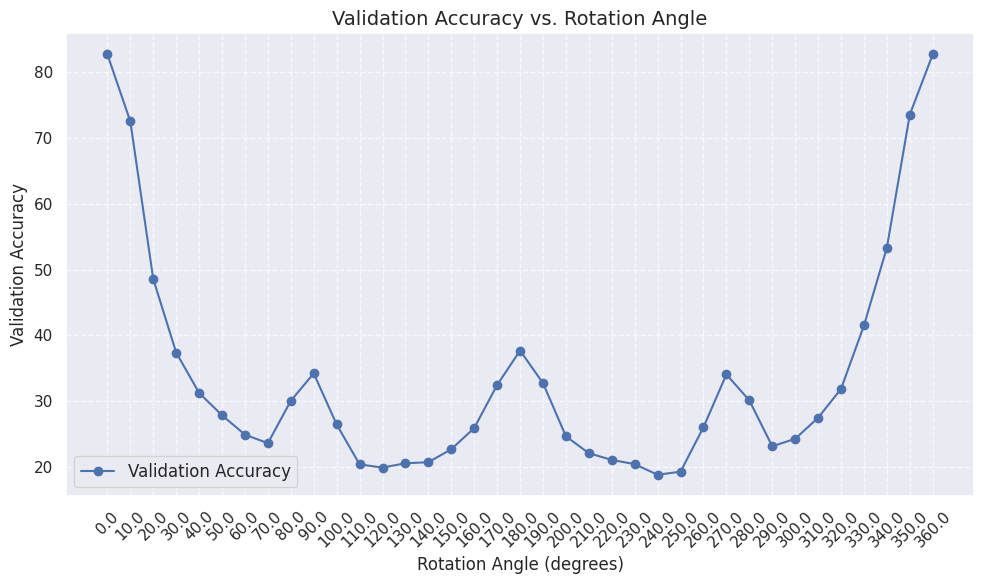

In [78]:
# TODO: Plot results
# Plot the validation accuracy over rotation angles
plt.figure(figsize=(10, 6))
plt.plot(rotation_angles, validation_accuracies, marker='o', linestyle='-', label="Validation Accuracy")
plt.title("Validation Accuracy vs. Rotation Angle", fontsize=14)
plt.xlabel("Rotation Angle (degrees)", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.xticks(rotation_angles, rotation_angles, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


What do these results indicate? Add this plot in your report and discuss it.

## Part 3: Pixel shuffling

In the first practical, we have investigated how the MLP reacts to shuffling the pixels of all images with a fixed, random permutation. Now, let's repeat this experiment for the CNNs. Does the CNN exploit the structural information differently than the MLP?

The first step is to create datasets with a new shuffling of pixels:

In [79]:
# TODO: Create datasets and data loaders with a fixed, random shuffle of pixels
fixed_permutation = torch.randperm(32 * 32 * 3)

# Transform for pixel shuffling (fixed)
class FixedPixelShuffleTransform:
    def __init__(self, permutation):
        self.permutation = permutation

    def __call__(self, img):
        img = torch.flatten(img)  # Flatten the image into a vector
        img = img[self.permutation]  # Apply the fixed permutation
        return img.view(3, 32, 32)  # Reshape to original dimensions

# Transform for pixel shuffling (random)
class RandomPixelShuffleTransform:
    def __call__(self, img):
        random_perm = torch.randperm(32 * 32 * 3)  # Generate a random permutation
        img = torch.flatten(img)  # Flatten the image into a vector
        img = img[random_perm]  # Apply the random permutation
        return img.view(3, 32, 32)  # Reshape to original dimensions

# Fixed shuffle transforms
fixed_shuffled_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    FixedPixelShuffleTransform(fixed_permutation),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])

fixed_shuffled_test_transform = transforms.Compose([
    transforms.ToTensor(),
    FixedPixelShuffleTransform(fixed_permutation),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])

fixed_shuffled_val_transform = transforms.Compose([
    transforms.ToTensor(),
    FixedPixelShuffleTransform(fixed_permutation),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])

# Random shuffle transforms
random_shuffled_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    RandomPixelShuffleTransform(),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])

random_shuffled_test_transform = transforms.Compose([
    transforms.ToTensor(),
    RandomPixelShuffleTransform(),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])

random_shuffled_val_transform = transforms.Compose([
    transforms.ToTensor(),
    RandomPixelShuffleTransform(),
    transforms.Normalize(DATA_MEANS, DATA_STD)
])


# Fixed shuffle datasets
fixed_shuffled_train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=fixed_shuffled_train_transform, download=False)
fixed_shuffled_test_dataset = CIFAR10(root=DATASET_PATH, train=False, transform=fixed_shuffled_test_transform, download=False)
fixed_shuffled_val_dataset = CIFAR10(root=DATASET_PATH, train=False, transform=fixed_shuffled_val_transform, download=False)


# Random shuffle datasets
random_shuffled_train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=random_shuffled_train_transform, download=False)
random_shuffled_test_dataset = CIFAR10(root=DATASET_PATH, train=False, transform=random_shuffled_test_transform, download=False)
random_shuffled_val_dataset = CIFAR10(root=DATASET_PATH, train=False, transform=random_shuffled_val_transform, download=False)


# Data loaders for fixed shuffle
fixed_shuffled_train_loader = data.DataLoader(fixed_shuffled_train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
fixed_shuffled_test_loader = data.DataLoader(fixed_shuffled_test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
fixed_shuffled_val_loader = data.DataLoader(fixed_shuffled_val_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

# Data loaders for random shuffle
random_shuffled_train_loader = data.DataLoader(random_shuffled_train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
random_shuffled_test_loader = data.DataLoader(random_shuffled_test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
random_shuffled_val_loader = data.DataLoader(random_shuffled_val_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=2)




In [80]:
# Fixed random permutation
fixed_shuffled_model, fixed_shuffled_results = train_model(
    save_name='Fixed_Shuffled_ResNet',
    max_epochs=10,
    model_hparams={"num_classes": 10,
                   "c_hidden": [16, 24, 32],
                   "num_blocks": [2, 2, 3]},
    optimizer_hparams={"lr": 0.01, "momentum": 0.9, "weight_decay": 1e-4},
    data_loaders={"train": fixed_shuffled_train_loader,
                  "val": fixed_shuffled_val_loader,  # Validation remains unshuffled
                  "test": fixed_shuffled_test_loader}
)

print(fixed_shuffled_results)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


trainer log dir:saved_models/practical2/Fixed_Shuffled_ResNet/lightning_logs/version_1
Found pretrained model at ./saved_models/practical2/Fixed_Shuffled_ResNet.ckpt, loading...
Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 76.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 75.40it/s]
model existed in ./saved_models/practical2/Fixed_Shuffled_ResNet.ckpt with result of {'test': 0.438400000333786, 'val': 0.438400000333786}
continue?
n
{'test': 0.438400000333786, 'val': 0.438400000333786}


Next, we can start the training of the model. You can limit your number of epochs to a smaller number like 10.

In [81]:
# TODO: Create datasets and data loaders with random shuffle of pixels
random_shuffled_model, random_shuffled_results = train_model(
    save_name='Random_Shuffled_ResNet',
    max_epochs=10,
    model_hparams={"num_classes": 10,
                   "c_hidden": [16, 24, 32],
                   "num_blocks": [2, 2, 3]},
    optimizer_hparams={"lr": 0.01, "momentum": 0.9, "weight_decay": 1e-4},
    data_loaders={"train": random_shuffled_train_loader,
                  "val": random_shuffled_val_loader,  # Validation remains unshuffled
                  "test": random_shuffled_test_loader}
)

print(random_shuffled_results)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


trainer log dir:saved_models/practical2/Random_Shuffled_ResNet/lightning_logs/version_1
Found pretrained model at ./saved_models/practical2/Random_Shuffled_ResNet.ckpt, loading...
Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 65.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 66.13it/s]
model existed in ./saved_models/practical2/Random_Shuffled_ResNet.ckpt with result of {'test': 0.21410000324249268, 'val': 0.218299999833107}
continue?
n
{'test': 0.21410000324249268, 'val': 0.218299999833107}


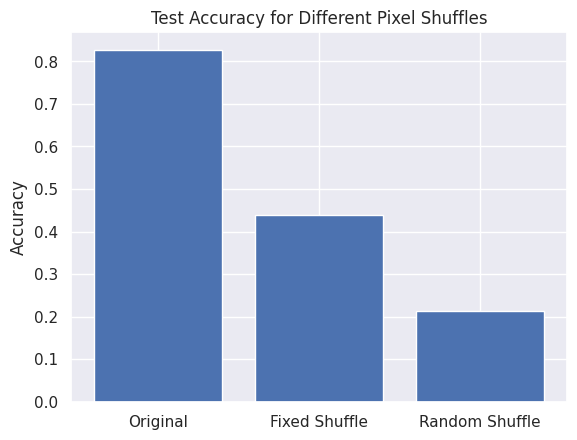

Results Summary:
Original Dataset - Test Accuracy: 0.8272, Validation Accuracy: 0.8342
Fixed Shuffle Dataset - Test Accuracy: 0.4384, Validation Accuracy: 0.4384
Random Shuffle Dataset - Test Accuracy: 0.2141, Validation Accuracy: 0.2183


In [82]:
# TODO: Print the results and look at your tensorboard
results = {
    "Original": resnet_results["test"],
    "Fixed Shuffle": fixed_shuffled_results["test"],
    "Random Shuffle": random_shuffled_results["test"]
}

labels, values = zip(*results.items())
plt.bar(labels, values)
plt.title("Test Accuracy for Different Pixel Shuffles")
plt.ylabel("Accuracy")
plt.show()


print("Results Summary:")
print(f"Original Dataset - Test Accuracy: {resnet_results['test']:.4f}, Validation Accuracy: {resnet_results['val']:.4f}")
print(f"Fixed Shuffle Dataset - Test Accuracy: {fixed_shuffled_results['test']:.4f}, Validation Accuracy: {fixed_shuffled_results['val']:.4f}")
print(f"Random Shuffle Dataset - Test Accuracy: {random_shuffled_results['test']:.4f}, Validation Accuracy: {random_shuffled_results['val']:.4f}")



In [83]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_PATH}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 26710), started 0:14:33 ago. (Use '!kill 26710' to kill it.)

In [84]:
%tensorboard --logdir {CHECKPOINT_PATH}

Reusing TensorBoard on port 6006 (pid 26710), started 0:14:34 ago. (Use '!kill 26710' to kill it.)

Add your observations to your report and discuss what this implies for CNNs.

## Conclusion

In this practical, you gained some handson experience with CNNs on computer vision for classification. Your experiments probably give you a good indication why CNNs are a very popular choice for computer vision problems, but also what they can and cannot do.